In [ ]:
# Import Data Manipulation Libaries
import pandas as pd 
import numpy as np 

# Import Data Visualization Libraries
import seaborn as sns 
import matplotlib.pyplot as plt 

# Import Filter Warning Libraries
import warnings
warnings.filterwarnings(action = 'ignore')

# Import Scikit- Learn Libraries
from sklearn.preprocessing import RobustScaler,MinMaxScaler,LabelEncoder,OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score,mean_absolute_error,mean_squared_error
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from collections import OrderedDict
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, cross_val_score,KFold

# Import Machine Learning Model Libraries
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor,AdaBoostRegressor
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.cluster import KMeans

# Multicolinearity test and treatment libraries
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.decomposition import PCA

# Import Neccessory Libraries
import optuna 
import researchpy

In [29]:
filepath = "https://raw.githubusercontent.com/rushikeshpatil-123/DeliveryLogistics_Model/refs/heads/main/data/raw/Delivery_Logistics.csv"

target = "package_weight_kg"

numerical_columns=['delivery_id','distance_km','package_weight_kg','delivery_rating','delivery_cost']

categorical_columns = ['delivery_partner','package_type','vehicle_type','delivery_mode', 'region', 'weather_condition','delivery_time_hours', 'expected_time_hours',
                       'delayed', 'delivery_status']

df = pd.read_csv(filepath)

# Segregate Numerical and Categorical Columns

numerical_col = df.select_dtypes(exclude = "object").columns
categorical_col = df.select_dtypes(include = "object").columns
                       

Winsorized column: delivery_id
Winsorized column: distance_km
Winsorized column: package_weight_kg
Winsorized column: delivery_rating
Winsorized column: delivery_cost


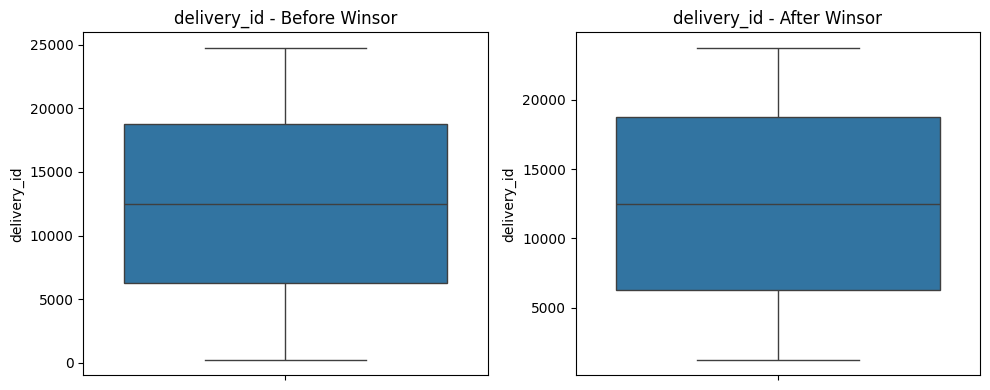

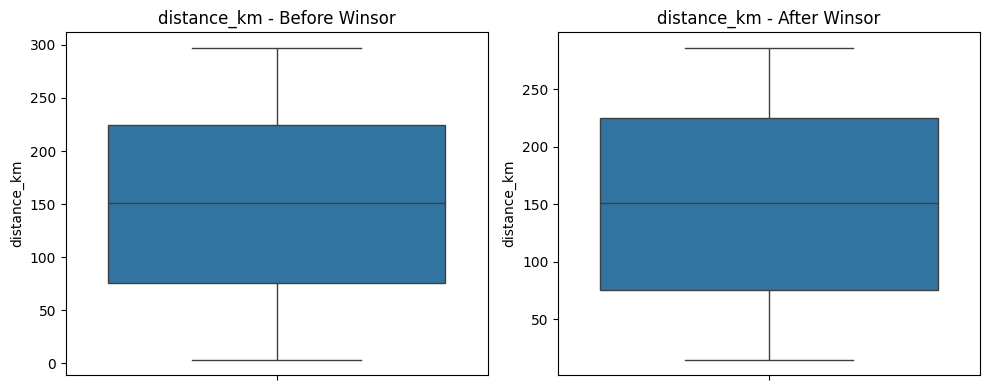

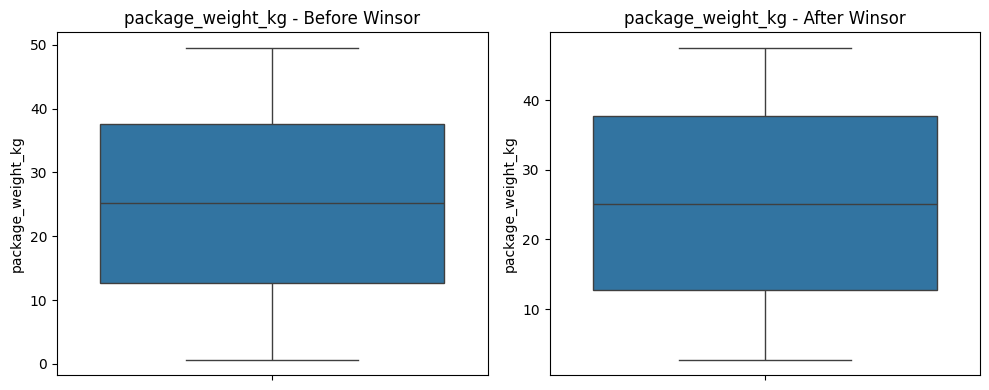

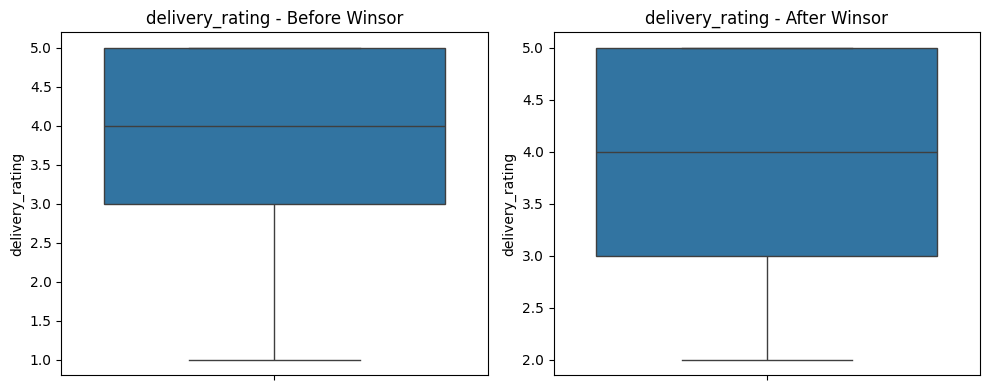

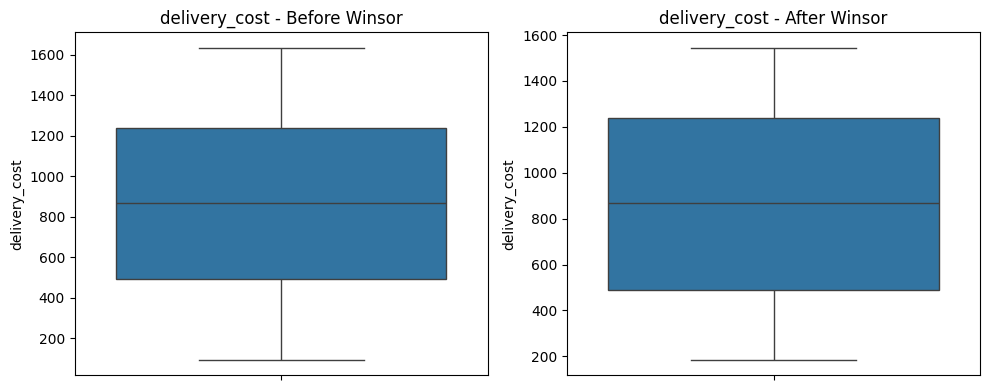

In [30]:
from scipy.stats.mstats import winsorize

# Create copy before winsorization
df_before_winsor = df.copy()

# Apply winsorization
for col in numerical_col:
    df[col] = winsorize(
        df[col],
        limits=(0.05, 0.05)  # 5% lower & upper capping
    )
    
    print(f"Winsorized column: {col}")

# Performance checking 

for col in numerical_col:
    plt.figure(figsize=(10,4))

    plt.subplot(1,2,1)
    sns.boxplot(y=df_before_winsor[col])
    plt.title(f"{col} - Before Winsor")

    plt.subplot(1,2,2)
    sns.boxplot(y=df[col])
    plt.title(f"{col} - After Winsor")

    plt.tight_layout()
    plt.show()
    

Winsorized column: delivery_partner
Winsorized column: package_type
Winsorized column: vehicle_type
Winsorized column: delivery_mode
Winsorized column: region
Winsorized column: weather_condition
Winsorized column: delivery_time_hours
Winsorized column: expected_time_hours
Winsorized column: delayed
Winsorized column: delivery_status


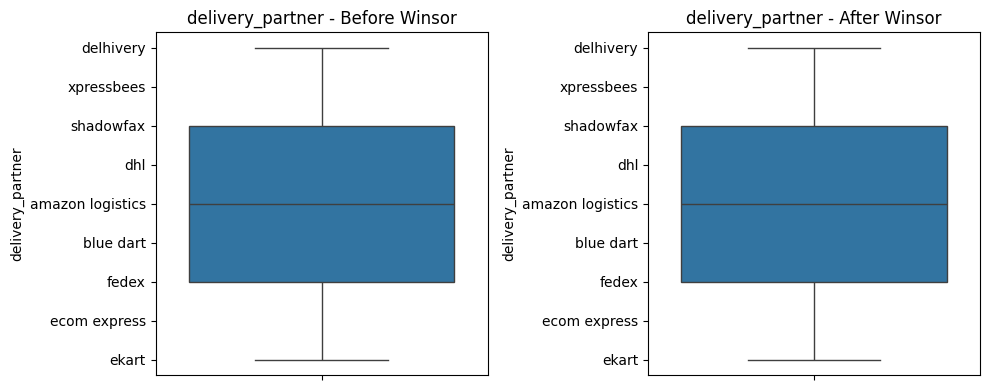

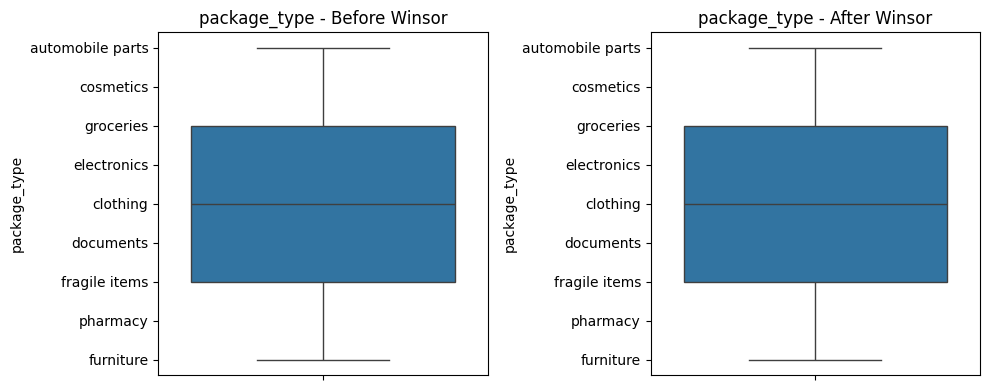

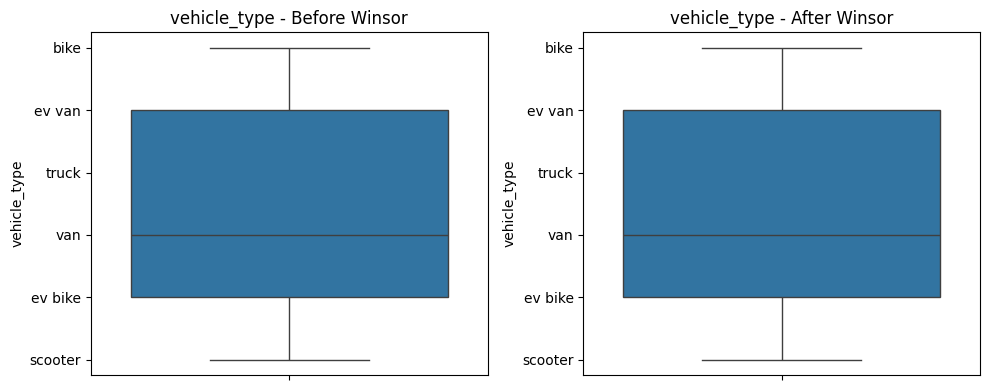

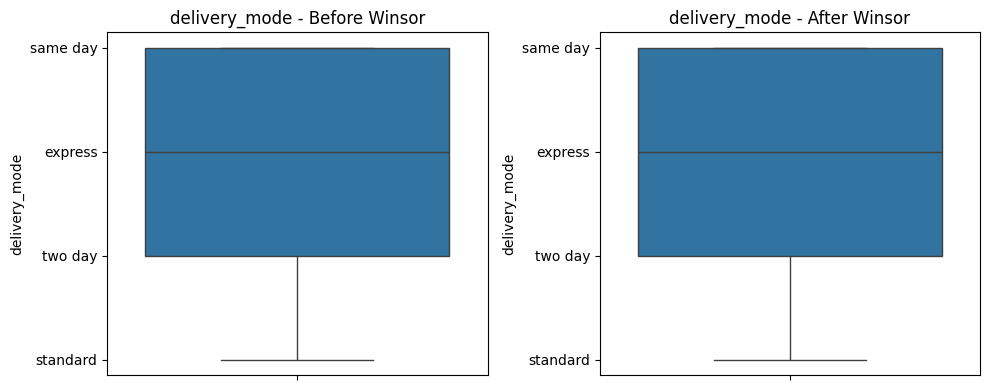

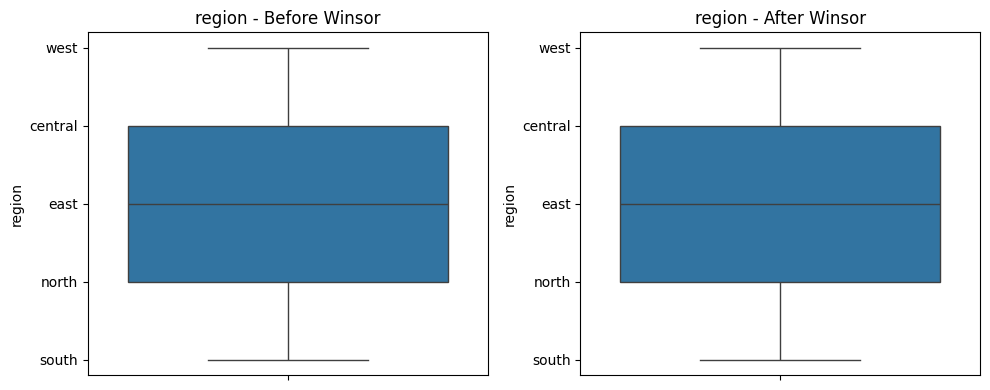

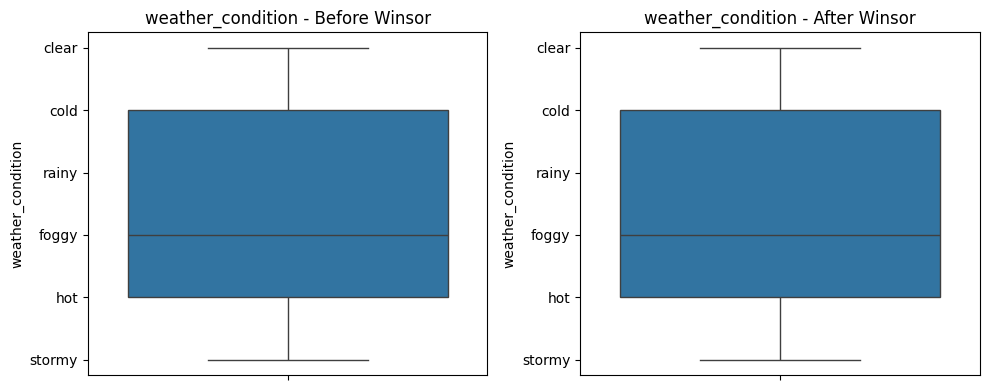

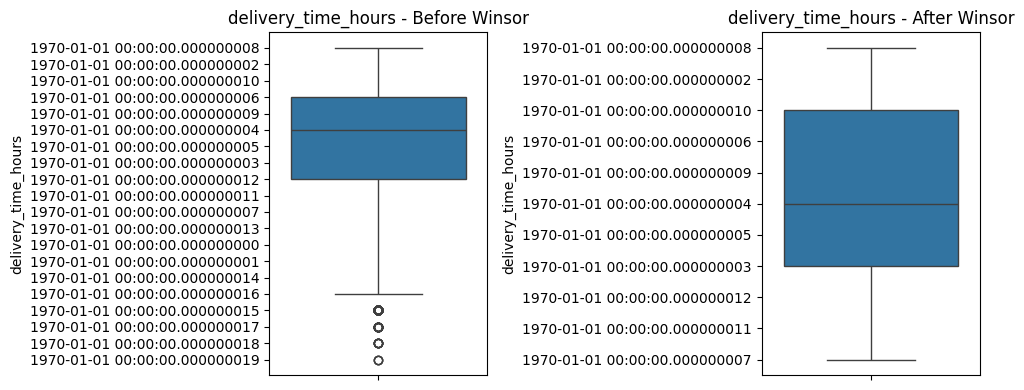

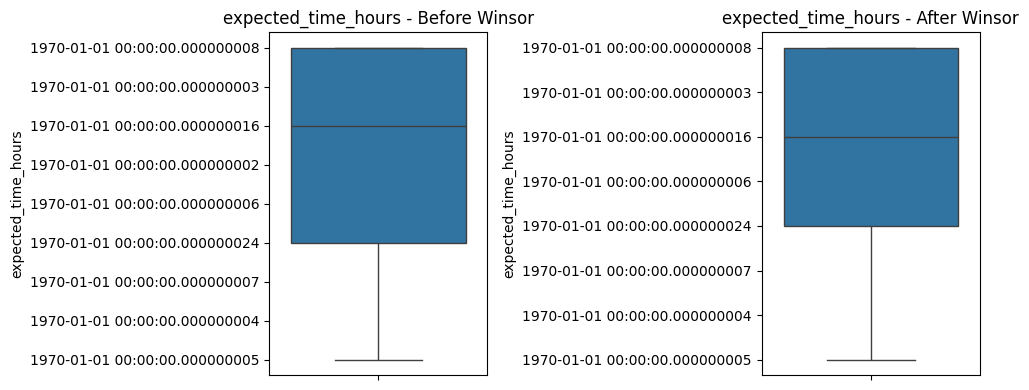

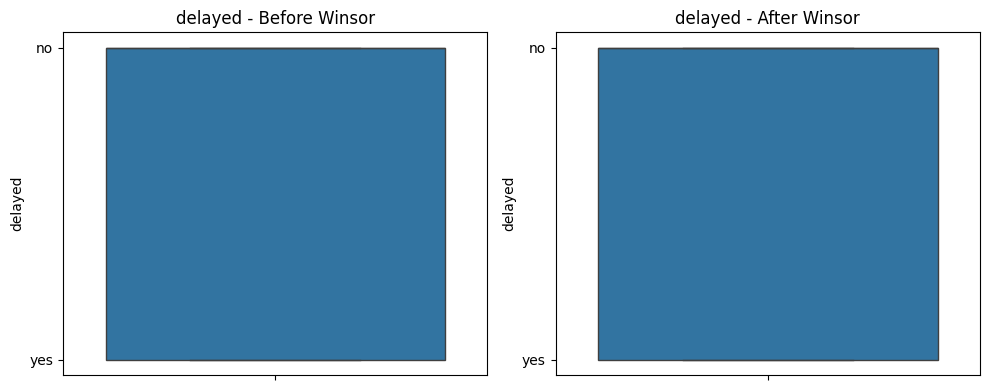

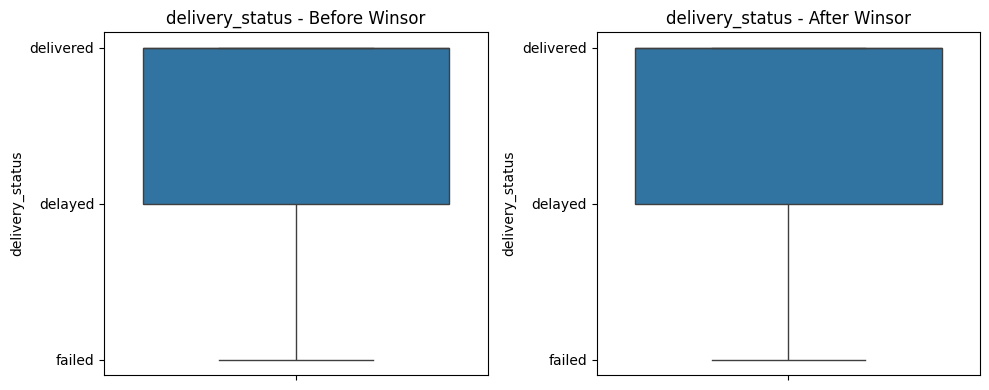

In [31]:
from scipy.stats.mstats import winsorize

# Create copy before winsorization
df_before_winsor = df.copy()

# Apply winsorization
for col in categorical_col:
    df[col] = winsorize(
        df[col],
        limits=(0.05, 0.05)  # 5% lower & upper capping
    )
    
    print(f"Winsorized column: {col}")

# Performance checking 

for col in categorical_col:
    plt.figure(figsize=(10,4))

    plt.subplot(1,2,1)
    sns.boxplot(y=df_before_winsor[col])
    plt.title(f"{col} - Before Winsor")

    plt.subplot(1,2,2)
    sns.boxplot(y=df[col])
    plt.title(f"{col} - After Winsor")

    plt.tight_layout()
    plt.show()

In [33]:
def split_data(data, target, test_size = 0.3, random_state = 42):

    X = data.drop(columns=['package_weight_kg'],axis =1 )
    y = data['package_weight_kg']

    categorical_col = X.select_dtypes(include = 'object').columns
    numerical_col = X.select_dtypes(exclude = 'object').columns

    numerical_pipeline = Pipeline(steps=[
        ("imputer", SimpleImputer(strategy="median")),
        ("scaler",MinMaxScaler()),
        ("pca",PCA(n_components=0.95))
    ])

    categorical_pipeline = Pipeline(steps=[
        ("imputer", SimpleImputer(strategy="most_frequent")),
        ("LabelEncoder",LabelEncoder(handle_unknown='ignore'))
    ])

    preprocessor = ColumnTransformer(transformers=[
        ("num", numerical_pipeline, numerical_columns),
        ("cat", categorical_pipeline,categorical_columns)

    ])

    X_train, X_test, y_train, y_test = train_test_split(
        X,y,
        test_size=test_size,
        random_state=random_state,
        stratify=y

    )

    X_train = preprocessor.fit_transform(X_train)
    X_test = preprocessor.transform(X_test)

    return X_train, X_test, y_train, y_test



In [35]:
def model_building():
    models = OrderedDict({
        "LinearRegression": LinearRegression(),
        "RandomForestRegressor":RandomForestRegressor(),
        "AdaBoostRegressor":AdaBoostRegressor(),
        "DecisionTreeRegressor":DecisionTreeRegressor(),
        "KNeighborsRegressor":KNeighborsRegressor(),
        "SVR":SVR()
        
    })

    return models

In [ ]:
def evaluate_model(data, target):

    X_train, X_test, y_train, y_test = split_data(data, target)
    models = model_building()

    results = []

    for model_name, model in models.items():
        model.fit(X_train,y_train)
        y_pred = model.predict(X_test)
        r2_score = r2_score(y_test, y_pred)

        results.append((model_name, r2_score))

    return results,X_train,X_test,y_train,y_test
